# Projeto 3 
##### Integração usando Álgebra Linear

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot as jt
jt.style(theme="gruvboxd")

## 2.1 Aplicações computacionais, mudanças de variáveis e erros numéricos
### Questão 1. 
 Escreva uma função $matrix$_$nodes(xs)$ que cria a matriz $M^T$ correspondente aos pontos $X$.

In [2]:
def matrix_nodes(xs):
    '''Retorna a Matriz de Vandermond M^T dado um vetor x'''
    M=np.vander(xs,increasing=True)
    return M.T

In [3]:
#Teste
t1=[-1,0,1] 
print(matrix_nodes(t1))

[[ 1  1  1]
 [-1  0  1]
 [ 1  0  1]]


### Questão 2.
Escreva uma função $weight$_$nodes(xs)$ que retorna o vetor de pesos $w$ para integrar no intervalo $[−1, 1]$. Verifique que $w$ corresponde aos pesos certos para os métodos do ponto médio, trapézio e Simpson.

In [4]:
def weight_nodes(xs):
    '''Retorna o vetor de pesos W dado um vetor x'''
    M_T = matrix_nodes(xs)
    v = [(1-(-1)**(1+n))/(1+n) for n in range(len(xs))]
    w = np.linalg.solve(M_T,v)
    return w

##### Verificação:
Verificando que W realmente corresponde as pesos para o Método do Ponto Médio, Trapézio e Simpson:

In [5]:
#teste
xt = [[0],[-1,1],[-1,0,1]]
certos = [ [2], [1,1], [1/3,4/3,1/3]]
pesos = [weight_nodes(xt) for xt in xt]
assert np.allclose(certos[0], pesos[0])
assert np.allclose(certos[1], pesos[1])
assert np.allclose(certos[2], pesos[2])

### Questão 3.
Escreva uma função $rule$_$nodes(xs)$ que retorna uma função $rule(f,ai,bi)$ para integrar $f$ no intervalo $[ai, bi]$. Faça as contas primeiro no intervalo-padrão $[−1, 1]$, e depois “normalize” de volta para o intervalo $[ai, bi]$.

In [6]:
def rule_nodes(xs):
    '''Retorna a função de integração de f dado um vetor x'''
    w = weight_nodes(xs)
    def rule(f,ai,bi):
        x_denorm = [((bi-ai)*x+ai+bi)/2 for x in xs]
        C = (bi-ai)/2
        f = np.vectorize(f)
        pi_x = f(x_denorm)*C
        return np.dot(pi_x,w)
    return rule

### Questão 4.
Escolha algumas funções e faça o gráfico do erro de integração em função do número de nós de interpolação escolhidos. (Integre pelo menos três funções “bem diferentes” para não analisar apenas um caso particular!)

Definindo algumas funções polinomiais, trigonométricas, e exponenciais.

In [7]:
#Funções
def f_1(x):
    return 3*np.cos(3*x)
def f_2(x):
    return 7*(x**(6))
def f_3(x):
    return 5*np.exp(5*x)
#Primitivas
def F_1(x):
    return np.sin(3*x)
def F_2(x):
    return x**(7)
def F_3(x):
    return np.exp(5*x)
#Listas referenciadas em plots
primitivas = [F_1,F_2,F_3]
func = [f_1,f_2,f_3]
names = ["Trigonométrica","Polinomial","Exponencial"]

In [8]:
def graph_err(f,F,a=-1,b=1,Ni=1,N=100):
    """Funcao que calcula o erro absoluto da integração do intervalo [a,b] variando o número de nós
    e retorna as listas de erros e de pontos do eixo x para plot"""
    ans = F(b)-F(a)
    err = []
    x_axis = np.arange(Ni,N+1)
    for k in range(Ni,N+1):
        x_nodes = np.linspace(a,b, num = k,endpoint=True)
        aux = rule_nodes(x_nodes)
        erro = abs(aux(f,a,b) - ans)
        err.append(erro)
    return err,x_axis

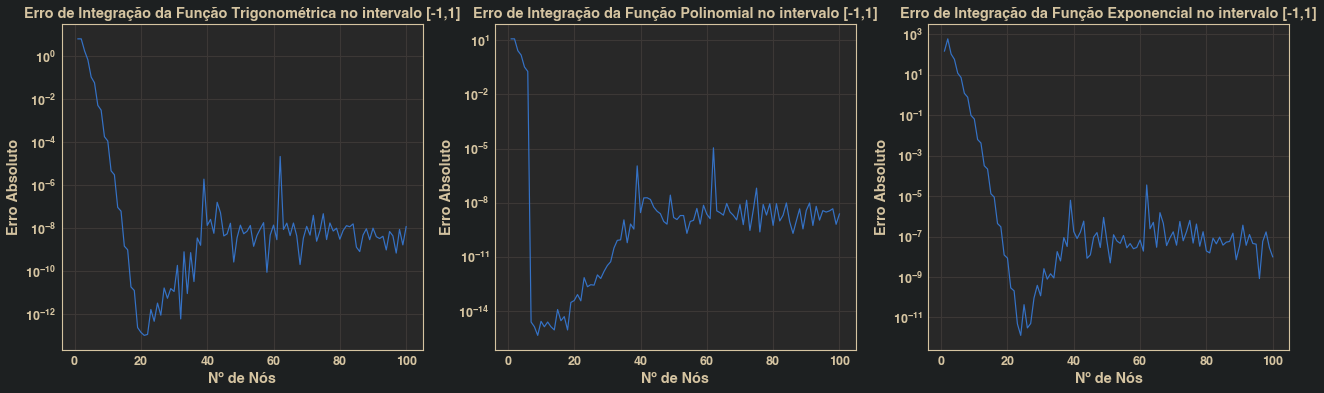

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(22,6))
for f,F,name,ax in zip(func,primitivas,names,axs):
    err, x = graph_err(f,F,a=-1,b=1)
    ax.semilogy(x,err)
    ax.set_title(f"Erro de Integração da Função {name} no intervalo [-1,1]")
    ax.set_xlabel("Nº de Nós")
    ax.set_ylabel("Erro Absoluto")

### Questão 5.
Para as mesmas funções, aumente e/ou reduza o tamanho do intervalo de integração:
será que o erro de integração continua com o mesmo comportamento?

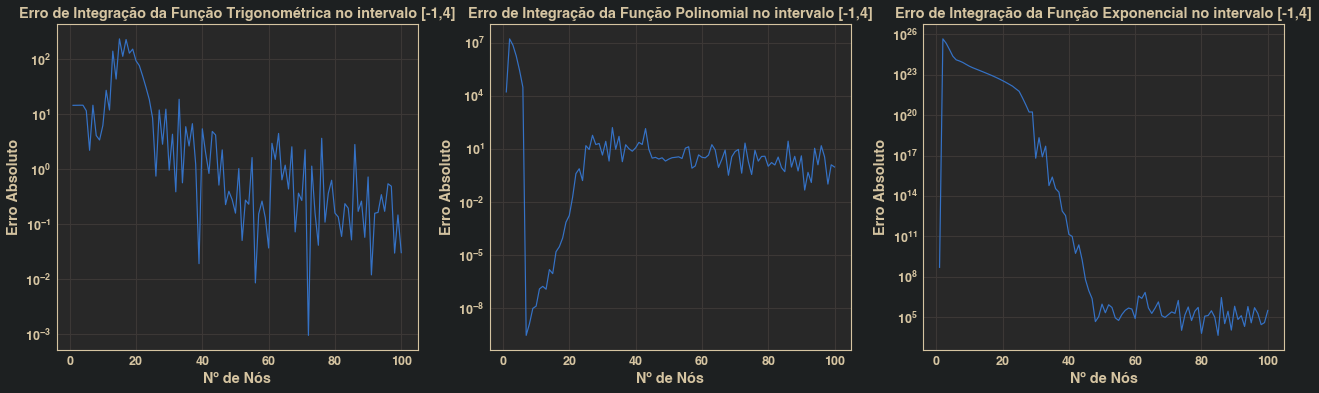

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(22,6))
for f,F,name,ax in zip(func,primitivas,names,axs):
    err, x = graph_err(f,F,a=-1,b=4,N=100)
    ax.semilogy(x,err)
    ax.set_title(f"Erro de Integração da Função {name} no intervalo [-1,4]")
    ax.set_xlabel("Nº de Nós")
    ax.set_ylabel("Erro Absoluto")

### Questão 6.
Para integrar funções em intervalos muito grandes, pode ser melhor dividir em blocos
do que “só” aumentar o grau do polinômio interpolador. Escreva uma função
integra(f,a,b,n,rule) que aplica a regra rule em n sub-intervalos de [a, b], para
aproximar a integral.

In [11]:
def integra(f,a,b,n,rule):
    """Dada um Intervalo [a,b],subdide-o em 'n' sub-intervalos e aplica rule para este sub-intervalo
    a fim de integrá-lo, no final retorna a soma das 'n' integrações de [a,b]"""
    I_t = 0
    sub_interv = np.linspace(a,b, num = n+1,endpoint=True)
    for i in range(n):
        I_i = rule(f,sub_interv[i],sub_interv[i+1])
        I_t+=I_i
    return I_t 

### Questão 7.
Faça o gráfico do erro de integração em função do número n de subdivisões [ai, bi] do
intervalo [a, b], para regras que usam, em cada sub-intervalo, 10, 15, 20 e 30 pontos.

In [12]:
def graph_err_sub(f,F,a=-1,b=1,Ni=1,N=100,nodes=2):
    """Função que calcula o erro absoluto da integração do intervalo [a,b] variando o número de sub-intervalos
    e retorna as listas de erros e de pontos do eixo x para plot"""
    ans = F(b)-F(a)
    err = []
    x_nodes = np.linspace(a,b,num=nodes,endpoint=True)
    aux = rule_nodes(x_nodes)
    n_sub = np.arange(Ni,N+1)
    for n in n_sub:
        I = integra(f,a,b,n,aux)
        erro = abs(I-ans)
        err.append(erro)
    return err,n_sub

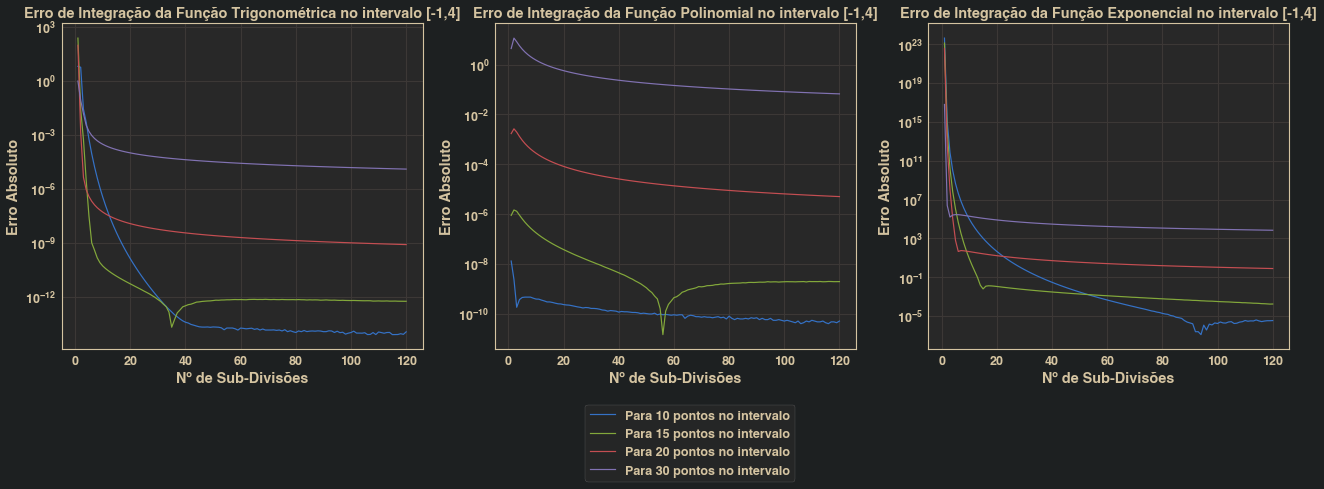

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(22,6))
for f,F,name,ax in zip(func,primitivas,names,axs):
    for k in [10,15,20,30]:
        err, n_sub = graph_err_sub(f,F,a=-1,b=4,N=120,nodes=k)
        ax.semilogy(n_sub,err,label=f"Para {k} pontos no intervalo")
        ax.set_xlabel("Nº de Sub-Divisões")
        ax.set_ylabel("Erro Absoluto")
    ax.set_title(f"Erro de Integração da Função {name} no intervalo [-1,4]")
ax.legend(bbox_to_anchor=(-0.35,-0.15));

### Questão 8.
Refaça os mesmos gráficos, agora com o erro em função do número total de pontos
do intervalo [a, b] onde foi avaliada a função f. Até quando aumentar o número de
pontos em X acelera a convergência? Como você explica este equilíbrio entre grau do
interpolador e número de sub-intervalos?

In [14]:
def graph_err_points(f,F,a=-1,b=1,Ni=1,N=100,n_sub=2):
    """Função que calcula o erro absoluto da integração do intervalo [a,b] variando o número de nós
    e retorna as listas de erros e de pontos totais do intervalo [a,b] x para plot"""
    ans = F(b)-F(a)
    err = []
    i=0
    x_axis = np.arange(Ni,N+1)
    x_nodes= [np.linspace(a,b,num=k) for k in range(Ni,N+1)]
    for p in x_nodes:
        aux = rule_nodes(p)
        I = integra(f,a,b,n_sub,aux)
        erro = abs(I-ans)
        err.append(erro)
        x_axis[i]= n_sub*(len(p)-1)+1
        i+=1
    return err,x_axis

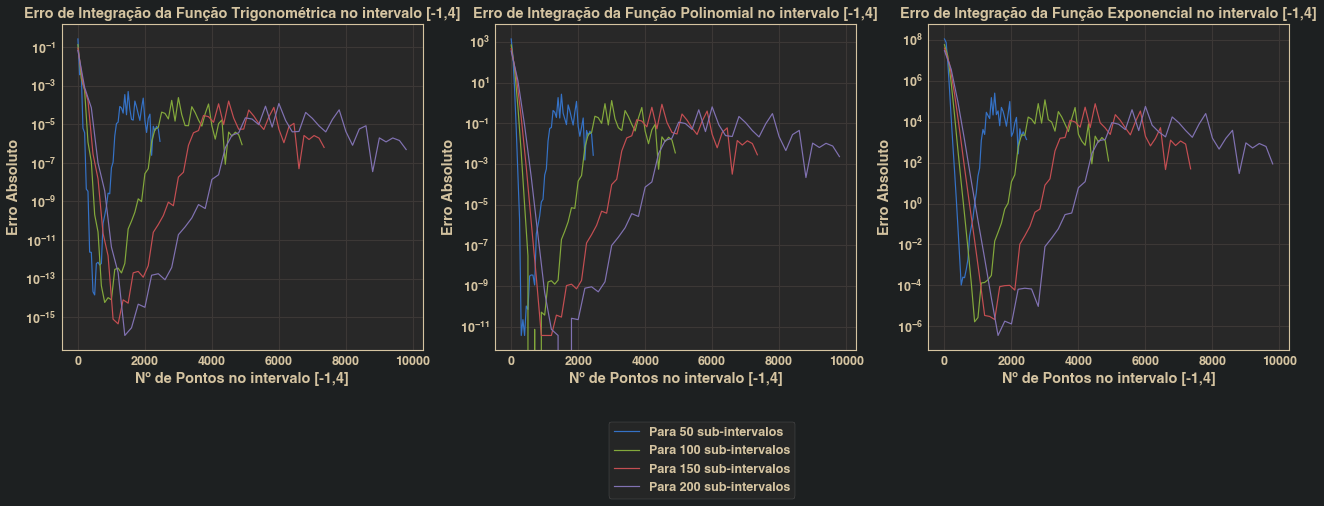

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(22,6))
for f,F,name,ax in zip(func,primitivas,names,axs):
    for k in [50,100,150,200]:
        err, n_points = graph_err_points(f,F,a=-1,b=4,N=50,n_sub=k)
        ax.semilogy(n_points,err,label=f"Para {k} sub-intervalos")
        ax.set_xlabel("Nº de Pontos no intervalo [-1,4]")
        ax.set_ylabel("Erro Absoluto")
    ax.set_title(f"Erro de Integração da Função {name} no intervalo [-1,4]")
ax.legend(bbox_to_anchor=(-0.35,-0.2));

Podemos ver que, em média, são somente necessários no máximo 2000 pontos para acelerar a convergência, mais do que isso começamos a ter mais erros de contas devido a uma matríz descenecessariamente grande.
O equilíbrio pode ser demonstrado se pensarmos que para distribuir de forma igualmente espaçadas N pontos num intervalo $[a,b]$ o grau do interpolador segue a seguinte relação: $$N = N_{sub} \bullet grau_{interpolador} + 1$$   

### Questão 9.
Refaça a análise dos dois métodos de integração, agora para nós de Chebyshev: primeiro,
apenas aumentando o grau do polinômio interpolador, e, em seguida, também
aumentando o número de sub-divisões. Qual a melhor combinação de grau/sub-divisões
que você encontra para cada função?

In [16]:
def cheby_nodes(n):
    """Função que calcula os N primeiros nós de Chebyshev"""
    return [np.cos(np.pi*((2*k-1)/(2*n)))for k in range(1,n+1)]
def graph_err_cheby(f,F,a=-1,b=1,Ni=1,N=100):
    """Funcao que calcula o erro absoluto da integração do intervalo [a,b] variando o número de nós
    e retorna as listas de erros e de pontos do eixo x para plot"""
    ans = F(b)-F(a)
    err = []
    x_axis = np.arange(Ni,N+1)
    for k in range(Ni,N+1):
        x_nodes = cheby_nodes(k)
        aux = rule_nodes(x_nodes)
        erro = abs(aux(f,a,b) - ans)
        err.append(erro)
    return err,x_axis

##### Mesma análise da questão 4

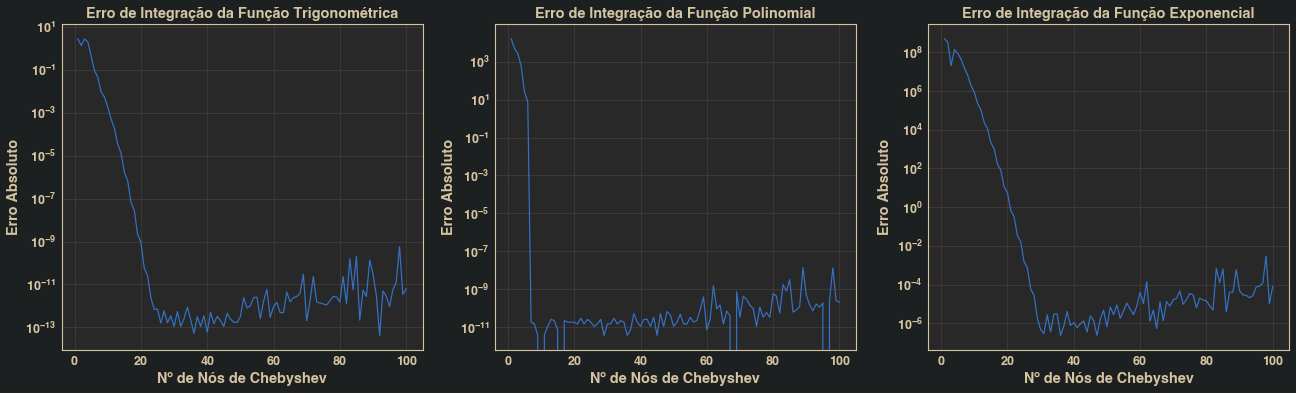

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(22,6))
for f,F,name,ax in zip(func,primitivas,names,axs):
    err, x = graph_err_cheby(f,F,a=-1,b=4)
    ax.semilogy(x,err)
    ax.set_title(f"Erro de Integração da Função {name}")
    ax.set_xlabel("Nº de Nós de Chebyshev")
    ax.set_ylabel("Erro Absoluto")

##### Mesma análisa da 7

In [18]:
def graph_err_cheby_nodes(f,F,a=-1,b=1,Ni=1,N=100,nodes=2):
    """Função que calcula o erro absoluto da integração do intervalo [a,b] variando o número de sub-intervalos
    e retorna as listas de erros e de pontos do eixo x para plot"""
    ans = F(b)-F(a)
    err = []
    x_nodes = cheby_nodes(nodes)
    aux = rule_nodes(x_nodes)
    n_sub = np.arange(Ni,N+1)
    for n in n_sub:
        I = integra(f,a,b,n,aux)
        erro = abs(I-ans)
        err.append(erro)
    return err,n_sub

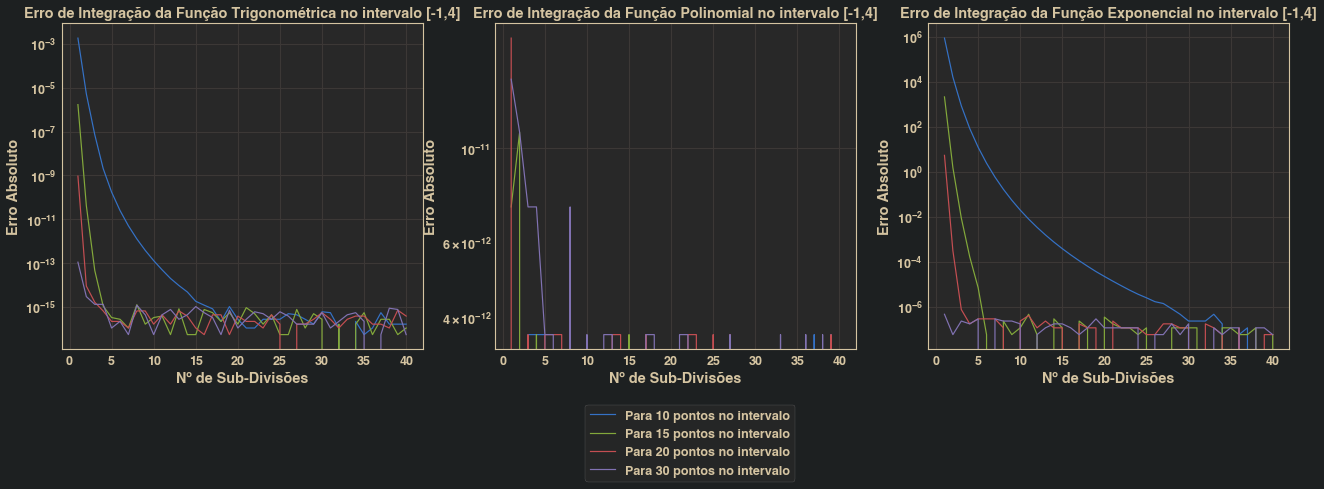

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(22,6))
for f,F,name,ax in zip(func,primitivas,names,axs):
    for k in [10,15,20,30]:
        err, n_sub = graph_err_cheby_nodes(f,F,a=-1,b=4,N=40,nodes=k)
        ax.semilogy(n_sub,err,label=f"Para {k} pontos no intervalo")
        ax.set_xlabel("Nº de Sub-Divisões")
        ax.set_ylabel("Erro Absoluto")
    ax.set_title(f"Erro de Integração da Função {name} no intervalo [-1,4]")
ax.legend(bbox_to_anchor=(-0.35,-0.15));

##### Mesma análise feita na 5 (porém com gráficos sobrepostos)

In [20]:
def graph_err_cheby_sub(f,F,a=-1,b=1,Ni=1,N=100,n_sub=2):
    """Função que calcula o erro absoluto da integração do intervalo [a,b] variando o número de nós
    e retorna as listas de erros e de pontos do eixo x para plot"""
    ans = F(b)-F(a)
    err = []
    i=0
    x_axis = np.arange(Ni,N+1)
    x_nodes= [np.linspace(a,b,num=k) for k in range(Ni,N+1)]
    for p in x_nodes:
        x_nodes = cheby_nodes(len(p))
        aux = rule_nodes(x_nodes)
        I = integra(f,a,b,n_sub,aux)
        erro = abs(I-ans)
        err.append(erro)
        x_axis[i]= n_sub*(len(p)-1)+1
        i+=1
    return err,x_axis

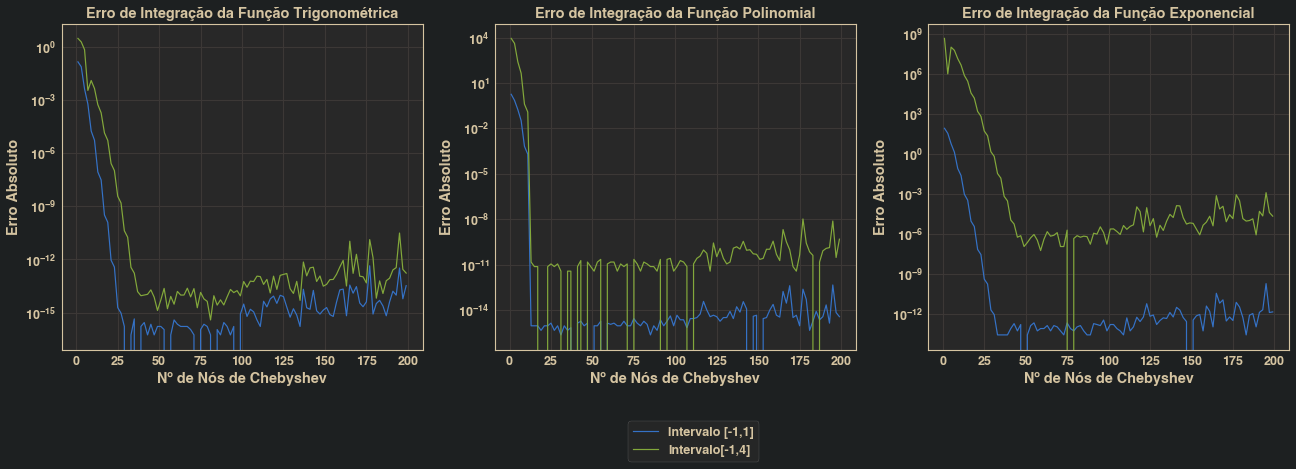

In [21]:
fig, axs = plt.subplots(ncols=3,figsize=(22,6))
for f,F,name,ax in zip(func,primitivas,names,axs):
    err, x = graph_err_cheby_sub(f,F,a=-1,b=1,N=100,n_sub=2)
    err4, x4 = graph_err_cheby_sub(f,F,a=-1,b=4,N=100,n_sub=2)
    ax.semilogy(x,err,label="Intervalo [-1,1]")
    ax.semilogy(x4,err4,label="Intervalo[-1,4]")
    ax.set_title(f"Erro de Integração da Função {name}")
    ax.set_xlabel("Nº de Nós de Chebyshev")
    ax.set_ylabel("Erro Absoluto")
ax.legend(bbox_to_anchor=(-0.45,-0.2));

Foi-se encontrado que a melhor combinação de grau e sub-divisões para cada função foram respectivamentes:

Para $f1 \longrightarrow (20,7)$

Para $f2 \longrightarrow (10,5)$

Para $f3 \longrightarrow (30,6)$

### Questão 10.
Compare com o uso de interpoladores em pontos igualmente espaçados.

Podemos ver apartir das analises feitas na questão 9 que ao usarmos os nós de Chebyshev, o erro ficou bem mais estável e estável em erros baixos em comparação com o uso de interpoladores igualmente espaçados das análises das questões 5 à 8. Para todas as funções analisada os gráficos de erros de Chebyshev tem uma tendencia de diminuição do erro seguida de estabilização em um valor de erro "mínimo" e oscilando pouco por volta dele.